In [1]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torchvision import datasets,models,transforms as T
import os
import torch.optim as optim
from PIL import ImageFile
from sklearn.metrics import accuracy_score

In [2]:
use_gpu = torch.backends.mps.is_available()
print(str(use_gpu))

True


In [3]:
batch_size = 16

img_transforms = {
    'train':
    T.Compose([
        T.Resize(size=(224,224)), 
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]), 
        ]),

    'test':
    T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
     }

data='./data/'

train_path=os.path.join(data,'train')
test_path=os.path.join(data,'test')

train_file=datasets.ImageFolder(train_path,transform=img_transforms['train'])
test_file=datasets.ImageFolder(test_path,transform=img_transforms['test'])

loaders_transfer={
    'train':torch.utils.data.DataLoader(train_file,batch_size,shuffle=True),
    'test': torch.utils.data.DataLoader(test_file,batch_size,shuffle=True)
}

In [4]:
model_transfer=models.resnet50(pretrained=True)
for param in model_transfer.parameters():
    param.requires_grad = False   
    
model_transfer.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2))

/Users/bala/ML/apple-tf-torch/torch/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bala/ML/apple-tf-torch/torch/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model_transfer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
summary(model_transfer, (3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [-1, 64, 112, 112]        (128)
├─ReLU: 1-3                              [-1, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [-1, 64, 56, 56]          --
├─Sequential: 1-5                        [-1, 256, 56, 56]         --
|    └─Bottleneck: 2-1                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-1                  [-1, 64, 56, 56]          (4,096)
|    |    └─BatchNorm2d: 3-2             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-3                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 56, 56]          (36,864)
|    |    └─BatchNorm2d: 3-5             [-1, 64, 56, 56]          (128)
|    |    └─ReLU: 3-6                    [-1, 64, 56, 56]          --
|    |    └─Conv2d: 3-7                  [-1, 256, 56, 56]  

In [7]:
mps_device = torch.device("mps")


In [8]:
model_transfer=model_transfer.to(mps_device)

In [9]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0005)

In [10]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_gpu, save_path):
    trainingloss = []
    accval = []
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0 
        correct = 0.0
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_gpu:
                data, target = data.to(mps_device), target.to(mps_device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step() 
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        
        accuracy = 100.*(correct/len(train_file))
        trainingloss.append(train_loss)
        accval.append(accuracy)
        print('Epoch: {} \tTraining Loss: {:.9f} \tAccuracy: {:.9f}'.format(
            epoch, 
            train_loss,
            accuracy
            ))
        
    return model, trainingloss,accval

In [11]:
n_epochs=10
model_transfer, train_loss,train_acc = train(n_epochs, loaders_transfer, 
                                   model_transfer, optimizer_transfer, 
                                   criterion_transfer, use_gpu, 'model_resnet50.pt')

Epoch: 1 	Training Loss: 0.313785553 	Accuracy: 86.913725846
Epoch: 2 	Training Loss: 0.258960962 	Accuracy: 89.553660528
Epoch: 3 	Training Loss: 0.251655370 	Accuracy: 89.816746802
Epoch: 4 	Training Loss: 0.234566897 	Accuracy: 90.533430101
Epoch: 5 	Training Loss: 0.227904499 	Accuracy: 90.955275333
Epoch: 6 	Training Loss: 0.215224072 	Accuracy: 91.358976685
Epoch: 7 	Training Loss: 0.213205904 	Accuracy: 91.563095346
Epoch: 8 	Training Loss: 0.203461900 	Accuracy: 92.098339835
Epoch: 9 	Training Loss: 0.203460395 	Accuracy: 92.134627597
Epoch: 10 	Training Loss: 0.194461212 	Accuracy: 92.601832532


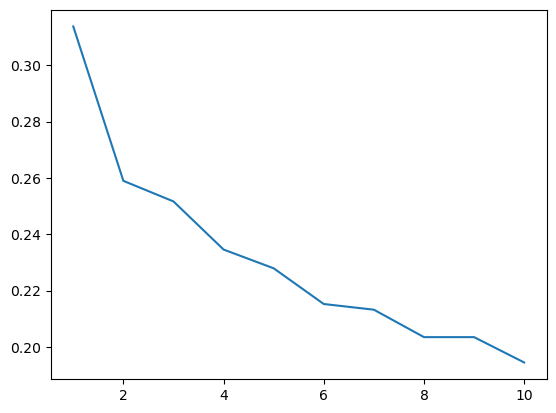

In [12]:
x = np.array([1,2,3,4,5,6,7,8,9,10]) 
y=[]

for i in range(10):
    y.append(train_loss[i].item())
  
plt.plot(x, y) 
plt.show()  

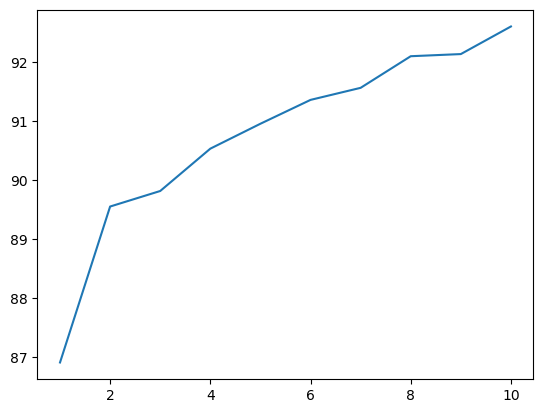

In [13]:
x = np.array([1,2,3,4,5,6,7,8,9,10]) 

  
plt.plot(x, train_acc) 
plt.show()  

In [14]:
def test(loaders, model, criterion, use_gpu):
    test_loss = 0.
    correct = 0.
    total = 0.
    preds = []
    targets = []

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        if use_gpu:
                data, target = data.to(mps_device), target.to(mps_device)
        output = model(data)
        loss = criterion(output, target)
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        pred = output.data.max(1, keepdim=True)[1]
        preds.append(pred)
        targets.append(target)
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
    
    return preds, targets, test_loss

preds, targets, testloss = test(loaders_transfer, model_transfer, criterion_transfer, use_gpu)

In [15]:
preds2, targets2 = [],[]

for i in preds:
    for j in range(len(i)):
        preds2.append(i.cpu().numpy()[j])
for i in targets:
    for j in range(len(i)):
        targets2.append(i.cpu().numpy()[j])

In [16]:
acc = accuracy_score(targets2, preds2)
print("Test Loss : ", testloss.cpu().numpy())
print("Test Accuracy : ", 100.*acc)

Test Loss :  0.16857891
Test Accuracy :  94.03120464441218


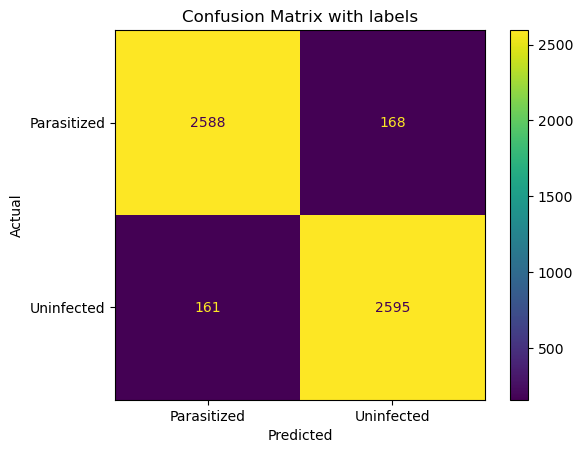

In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(targets2, preds2)

cmob = ConfusionMatrixDisplay(cm, display_labels=['Parasitized', 'Uninfected'])

cmob.plot()

cmob.ax_.set(title='Confusion Matrix with labels', 
            xlabel='Predicted', 
            ylabel='Actual')

plt.show()

In [18]:
torch.save(model_transfer.state_dict(), 'Resnet50_M1.pt')

In [19]:
def precision(tp,fp):
    prec = tp/(tp+fp)
    return prec

In [20]:
def recall(tp,fn):
    rec = tp/(tp+fn)
    return rec

In [21]:
def f1(prec,rec):
    f=(2*prec*rec)/(prec+rec)
    return f

In [22]:
tp=2588
tn=2595
fp=161
fn=168
prec = precision(tp,fp)
rec = recall(tp,fn)
f=f1(prec,rec)

In [23]:
print("Precision:  {}".format(prec))

Precision:  0.9414332484539832


In [24]:
print("Recall:  {}".format(rec))

Recall:  0.9390420899854862


In [25]:
print("F1-Score:  {}".format(f))

F1-Score:  0.940236148955495
